In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
import anndata as ad
import scanpy as sc
from adata_hf_datasets import AnnDataSetConstructor, InitialEmbedder
from sentence_transformers import SentenceTransformer

from mmcontext.embed.model_utils import encode_adata
from mmcontext.eval import OmicsQueryAnnotator

In [18]:
model_id = "jo-mengr/mmcontext-pubmedbert-gs10k-cxg_normlog-v2"
emb_method = "gs10k"
emb_key = f"X_{emb_method}"

In [5]:
model = SentenceTransformer(model_id, trust_remote_code=True)

Loaded encoder was registered for 'gs10k' data. Call register_initial_embeddings() with compatible data before using it.


In [ ]:
adata = sc.datasets.pbmc3k()
print(adata.X.min(), adata.X.max())
# normalise and log transform
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
print(adata.X.min(), adata.X.max())

0.0 419.0
0.0 5.955077


In [ ]:
# set gene_ids as index. If there are no gene_ids in the dataset,
# check from adata_hf_datasets.pp import ensure_ensembl_index
adata.var.index = adata.var["gene_ids"]

In [24]:
# create initial embeddings and create a hf dataset
embedder = InitialEmbedder(method=emb_method)
embedder.prepare(adata)
embeddings = embedder.embed(adata)
adata.obsm[emb_key] = embeddings

GeneSelectEmbedder embedding_dim is determined by the gene list. Ignoring provided value: 64
Dataset missing 244 genes, filled with zeros


In [25]:
adata.obs["sample_idx"] = adata.obs.index
# write processed adata to h5ad
processed_path = "pbmc3k_pp.h5ad"
adata.write_h5ad(processed_path)
# single format for inference datasets (no descriptions)
constructor = AnnDataSetConstructor(dataset_format="single")
# A sentence key refers to the column in adata.obs that is used to represent the sample.
# For numeric data, we use the sample index, and later register the created embedding linked to their indices in the tokenizer
constructor.add_anndata(adata, sentence_keys=["sample_idx"], adata_link=processed_path)
ds = constructor.get_dataset()

Generating train split: 0 examples [00:00, ? examples/s]

In [26]:
ds

Dataset({
    features: ['sample_idx', 'cell_sentence_1', 'adata_link'],
    num_rows: 2700
})

In [ ]:
adata = encode_adata(
    model,
    ds,
    adata,
    layer_key=emb_key,
    adata_download_dir="data_cache",
    main_col="cell_sentence_1",
    index_col="sample_idx",
    axis="obs",
    text_only=False,
)

Processing:   0%|          | 0/1 [00:00<?, ?file/s]

Use the returned DataFrame to register the embeddings with `register_initial_embeddings()`.


Prefixing columns: ['cell_sentence_1']:   0%|          | 0/2700 [00:00<?, ? examples/s]

Batches:   0%|          | 0/85 [00:00<?, ?it/s]

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


Neighbors computed from: mmcontext_emb
Embedding shape: (2700, 2048)


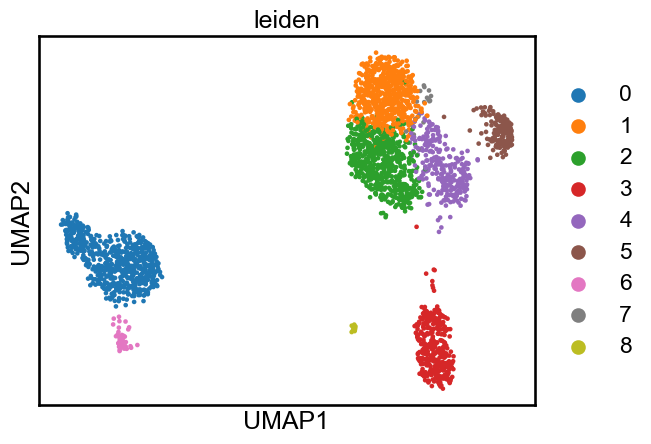

In [56]:
key_to_plot = "mmcontext_emb"
# perform leiden clustering
del adata.uns["neighbors"]
# Clean up any old leiden color palettes
if "leiden_colors" in adata.uns:
    del adata.uns["leiden_colors"]
# Compute neighbors graph using the specified embedding with cosine distance
sc.pp.neighbors(adata, use_rep=key_to_plot, metric="cosine")
# Verify which representation was used (stored in neighbors params)
print(f"Neighbors computed from: {adata.uns['neighbors']['params']['use_rep']}")
print(f"Embedding shape: {adata.obsm[key_to_plot].shape}")
sc.tl.leiden(adata)
# Compute UMAP for visualization (uses the neighbors graph computed above)
umap_key = f"X_umap_{key_to_plot}"  # Store with explicit key
sc.tl.umap(adata, neighbors_key="neighbors")
sc.pl.umap(adata, color=["leiden"])

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:112: RuntimeWarning: divide by zero encountered in matmul
  similarity_matrix = data_emb @ label_emb.T
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:112: RuntimeWarning: overflow encountered in matmul
  similarity_matrix = data_emb @ label_emb.T
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/query_annotate.py:112: RuntimeWarning: invalid value encountered in matmul
  similarity_matrix = data_emb @ label_emb.T


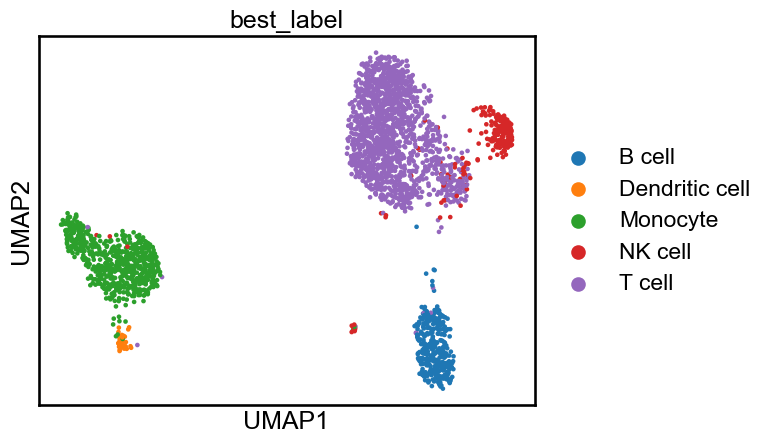

In [ ]:
annotator = OmicsQueryAnnotator(model)
query_labels = ["T cell", "B cell", "NK cell", "Monocyte", "Dendritic cell"]
annotator.annotate_omics_data(adata, labels=query_labels, emb_key="mmcontext_emb")
# colour umap by "best_label" created by the annotator
sc.pl.umap(adata, color=["best_label"])

In [ ]:
# Check out evaluate_model.ipynb for furhter examples, also showing the joint embedding
# That other tutorial doesnt use the abstracted helper function, to show a bit more about the internals